In [2]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [6]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     |████████████████████████████████| 166.7 MB 3.3 kB/s s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p37/bin/python -m pip install --upgrade pip' command.


In [2]:
## Training with weather data

In [5]:
import pandas as pd
import numpy as np
from datetime import datetime
import holidays
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
#import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from scipy.stats import  randint
from scipy.stats import uniform
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Build X_train

In [4]:
df_train = pd.read_csv('fl_wea_train.csv')

Text(0.5, 1.0, 'Distribution of delay in minutes')

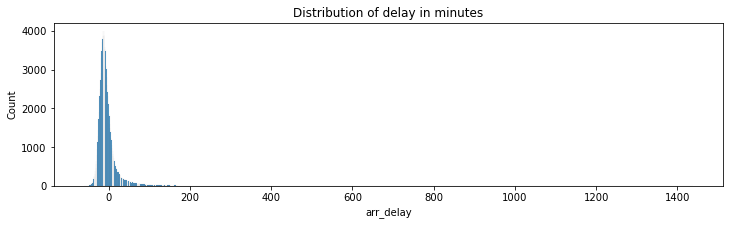

In [7]:
plt.figure(figsize=(12,3))
sns.histplot(df_train['arr_delay'])
plt.title('Distribution of delay in minutes')

In [5]:
col = df_train.columns.tolist()

In [28]:
col = ['fl_date', 'op_unique_carrier', 'op_carrier_fl_num', 'origin_airport_id', 'dest_airport_id',
 'crs_dep_time',  'crs_arr_time', 'arr_delay',  'distance',     
 'tmpf', 'sknt', 'vsby', 'gust', 'skyl1', 'ice_accretion_3hr',
 'tmpf_arr', 'sknt_arr', 'vsby_arr', 'gust_arr', 'skyl1_arr', 'ice_accretion_3hr_arr']

In [20]:
X_train = df_train[col]

In [61]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 949679 entries, 0 to 951087
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   fl_date                949679 non-null  object 
 1   arr_delay              949679 non-null  float64
 2   distance               949679 non-null  float64
 3   tmpf                   949679 non-null  float64
 4   sknt                   949679 non-null  float64
 5   vsby                   949679 non-null  float64
 6   gust                   949679 non-null  float64
 7   skyl1                  949679 non-null  float64
 8   ice_accretion_3hr      949679 non-null  float64
 9   tmpf_arr               949679 non-null  float64
 10  sknt_arr               949679 non-null  float64
 11  vsby_arr               949679 non-null  float64
 12  gust_arr               949679 non-null  float64
 13  skyl1_arr              949679 non-null  float64
 14  ice_accretion_3hr_arr  949679 non-nu

In [21]:
# after test data, arr_delay should be 0. 
X_train['arr_delay'].fillna(0,inplace=True)

#remove outliner
X_train = X_train[(X_train['arr_delay'] > -80) & (X_train['arr_delay'] <= 480)] 

#combine features
def combine_str_num(x,y):
    return x + str(y)
X_train['uni_fl'] = np.vectorize(combine_str_num)(X_train['op_unique_carrier'],X_train['op_carrier_fl_num'])
X_train.drop(columns=['op_unique_carrier','op_carrier_fl_num'],inplace=True)

# target encoding -- flight numbers
total_target_mean = np.mean(X_train['arr_delay'])
unifl_target_mean = X_train.groupby(['uni_fl'])['arr_delay'].mean()
X_train['uni_fl'] =X_train['uni_fl'].map(unifl_target_mean)



In [ ]:
# target encoding -- flight numbers
total_target_mean = np.mean(X_train['arr_delay'])
unifl_target_mean = X_train.groupby(['uni_fl'])['arr_delay'].mean()
X_train['uni_fl'] =X_train['uni_fl'].map(unifl_target_mean)

# target  encoding -- airport in detail hour
dep_hour_target_mean = X_train.groupby(['dep_airport_hour'])['arr_delay'].mean()
X_train['dep_airport_hour'] =X_train['dep_airport_hour'].map(dep_hour_target_mean)
arr_hour_target_mean = X_train.groupby(['arr_airport_hour'])['arr_delay'].mean()
X_train['arr_airport_hour'] =X_train['arr_airport_hour'].map(arr_hour_target_mean

In [22]:
## Combine the airportid and related hour
## Combine the airportid and related hour
def airport_hour(id,t):
    '''
    combine airport and hour to a new field
    '''
    t = t // 100
    if t == 24:
        t = 0
    l = '0' + str(t)
    return str(id) + l[-2:]
    
X_train['arr_airport_hour'] = np.vectorize(airport_hour)(X_train['dest_airport_id'],X_train['crs_arr_time'])
X_train['dep_airport_hour'] = np.vectorize(airport_hour)(X_train['origin_airport_id'],X_train['crs_dep_time'])

# feature coding
dep_hour_target_mean = X_train.groupby(['dep_airport_hour'])['arr_delay'].mean()
X_train['dep_airport_hour'] =X_train['dep_airport_hour'].map(dep_hour_target_mean)
arr_hour_target_mean = X_train.groupby(['arr_airport_hour'])['arr_delay'].mean()
X_train['arr_airport_hour'] =X_train['arr_airport_hour'].map(arr_hour_target_mean)

X_train.drop(columns=['dest_airport_id','crs_arr_time','origin_airport_id','crs_dep_time'],inplace=True)

In [23]:
pi=3.14159
def transformation(column):
  max_value = column.max()
  sin_values = [math.sin((2*pi*x)/max_value) for x in list(column)]
  cos_values = [math.cos((2*pi*x)/max_value) for x in list(column)]
  return sin_values, cos_values

#transform fl_date
#def getmonth(x):
#    return x.split(sep='-')[1]
#X_train['month'] = X_train['fl_date'].apply(getmonth)

#sin_m, cos_m = transformation(X_train['month'].astype('int32'))
#X_train['mon_sin'] = sin_m
#X_train['mon_cos'] = cos_m


def getdayofweek(x):
    year_s, mon_s, day_s = x.split('-')
    fl_d = datetime(int(year_s), int(mon_s), int(day_s))
    return fl_d.weekday() + 1
X_train['day_of_week'] = X_train['fl_date'].apply(getdayofweek)

us_holidays = holidays.UnitedStates()
def isholiday(x):
    year_s, mon_s, day_s = x.split('-')
    if datetime(int(year_s), int(mon_s), int(day_s)) in us_holidays:
        return 1
    else:
        return 0
X_train['is_holiday'] = X_train['fl_date'].apply(isholiday)



sin_l, cos_l = transformation(X_train['day_of_week'])

X_train['dow_sin'] = sin_l
X_train['dow_cos'] = cos_l

In [24]:
y_train = X_train['arr_delay']

X_train = X_train.drop(columns=['fl_date','arr_delay','day_of_week'])

#X_train = pd.get_dummies(X_train,columns=['month','day_of_week'])

In [86]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [ ]:
#x_small = X[:100000]
#y_small = y_train[:100000]

### Build X_test

In [14]:
df_test = pd.read_csv('fl_wea_eval.csv')

In [72]:
col=['fl_date','mkt_carrier','mkt_carrier_fl_num','origin','dest','predicted_delay']

In [12]:
df_test=df_test[col]

In [36]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147051 entries, 0 to 147050
Data columns (total 39 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             147051 non-null  int64  
 1   fl_date                147051 non-null  object 
 2   op_unique_carrier      147051 non-null  object 
 3   op_carrier_fl_num      147051 non-null  int64  
 4   origin_airport_id      147051 non-null  int64  
 5   dest_airport_id        147051 non-null  int64  
 6   crs_dep_time           147051 non-null  int64  
 7   dep_delay              146354 non-null  float64
 8   crs_arr_time           147051 non-null  int64  
 9   arr_delay              146132 non-null  float64
 10  cancelled              147051 non-null  float64
 11  cancellation_code      739 non-null     object 
 12  crs_elapsed_time       147051 non-null  float64
 13  distance               147051 non-null  float64
 14  carrier_delay          17806 non-nul

In [37]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147051 entries, 0 to 147050
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   arr_delay              146132 non-null  float64
 1   distance               147051 non-null  float64
 2   tmpf                   147051 non-null  float64
 3   sknt                   147051 non-null  float64
 4   vsby                   147051 non-null  float64
 5   gust                   147051 non-null  float64
 6   skyl1                  147051 non-null  float64
 7   ice_accretion_3hr      147051 non-null  float64
 8   tmpf_arr               147051 non-null  float64
 9   sknt_arr               147051 non-null  float64
 10  vsby_arr               147051 non-null  float64
 11  gust_arr               147051 non-null  float64
 12  skyl1_arr              147051 non-null  float64
 13  ice_accretion_3hr_arr  147051 non-null  float64
 14  uni_fl                 147051 non-nu

(-80.0, 150.0)

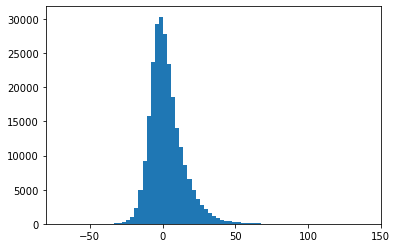

In [141]:
plt.hist(y_pred,bins=100)
#plt.hist(X_train['arr_delay'],bins=300)
plt.xlim(-80,150)

In [15]:
col = ['fl_date', 'op_unique_carrier', 'op_carrier_fl_num', 'origin_airport_id', 'dest_airport_id',
 'crs_dep_time',  'crs_arr_time',   'distance',     
 'tmpf', 'sknt', 'vsby', 'gust', 'skyl1', 'ice_accretion_3hr',
 'tmpf_arr', 'sknt_arr', 'vsby_arr', 'gust_arr', 'skyl1_arr', 'ice_accretion_3hr_arr']

In [43]:
X_test = df_test[col]

In [44]:
# after test data, arr_delay should be 0. 
X_test['arr_delay'].fillna(0,inplace=True)

#remove outliner
#X_test = X_test[(X_test['arr_delay'] > -80) & (X_test['arr_delay'] < 480)] 

#combine features
def combine_str_num(x,y):
    return x + str(y)
X_test['uni_fl'] = np.vectorize(combine_str_num)(X_test['op_unique_carrier'],X_test['op_carrier_fl_num'])
X_test.drop(columns=['op_unique_carrier','op_carrier_fl_num'],inplace=True)

# feature coding
#unifl_target_mean = X_test.groupby(['uni_fl'])['arr_delay'].mean()
X_test['uni_fl'] =X_test['uni_fl'].map(unifl_target_mean)
X_test['uni_fl'].fillna(total_target_mean,inplace=True)

In [45]:
## Combine the airportid and related hour

    
X_test['arr_airport_hour'] = np.vectorize(airport_hour)(X_test['dest_airport_id'],X_test['crs_arr_time'])
X_test['dep_airport_hour'] = np.vectorize(airport_hour)(X_test['origin_airport_id'],X_test['crs_dep_time'])


# feature coding
#dep_hour_target_mean = X_train.groupby(['dep_airport_hour'])['arr_delay'].mean()
X_test['dep_airport_hour'] =X_test['dep_airport_hour'].map(dep_hour_target_mean)
#arr_hour_target_mean = X_train.groupby(['arr_airport_hour'])['arr_delay'].mean()
X_test['arr_airport_hour'] =X_test['arr_airport_hour'].map(arr_hour_target_mean)

X_test['arr_airport_hour'].fillna(total_target_mean,inplace=True)
X_test['dep_airport_hour'].fillna(total_target_mean,inplace=True)

X_test.drop(columns=['dest_airport_id','crs_arr_time','origin_airport_id','crs_dep_time'],inplace=True)

In [46]:

#transform fl_date
#def getmonth(x):
#    return x.split(sep='-')[1]
#X_test['month'] = X_test['fl_date'].apply(getmonth)

#sin_m, cos_m = transformation(X_test['month'].astype('int32'))
#X_test['mon_sin'] = sin_m
#X_test['mon_cos'] = cos_m

def getdayofweek(x):
    year_s, mon_s, day_s = x.split('-')
    fl_d = datetime(int(year_s), int(mon_s), int(day_s))
    return fl_d.weekday() + 1
X_test['day_of_week'] = X_test['fl_date'].apply(getdayofweek)

us_holidays = holidays.UnitedStates()
def isholiday(x):
    year_s, mon_s, day_s = x.split('-')
    if datetime(int(year_s), int(mon_s), int(day_s)) in us_holidays:
        return 1
    else:
        return 0
X_test['is_holiday'] = X_test['fl_date'].apply(isholiday)



pi=3.14159
def transformation(column):
  max_value = column.max()
  sin_values = [math.sin((2*pi*x)/max_value) for x in list(column)]
  cos_values = [math.cos((2*pi*x)/max_value) for x in list(column)]
  return sin_values, cos_values

sin_l, cos_l = transformation(X_test['day_of_week'])

X_test['dow_sin'] = sin_l
X_test['dow_cos'] = cos_l



In [47]:
y_test = X_test['arr_delay']
X_test = X_test.drop(columns=['fl_date','day_of_week','arr_delay'])

#X_test = pd.get_dummies(X_test,columns=['month','day_of_week'])

#X_test = scaler.transform(X_test)

In [55]:
X_test.columns.tolist()

['distance',
 'tmpf',
 'sknt',
 'vsby',
 'gust',
 'skyl1',
 'ice_accretion_3hr',
 'tmpf_arr',
 'sknt_arr',
 'vsby_arr',
 'gust_arr',
 'skyl1_arr',
 'ice_accretion_3hr_arr',
 'uni_fl',
 'arr_airport_hour',
 'dep_airport_hour',
 'is_holiday',
 'dow_sin',
 'dow_cos']

In [1]:
###  XGBoost Modeling

In [17]:
## build benchmark
mean_train = np.mean(y_train)
# Get predictions on the test set
baseline_predictions = np.ones(y_test.shape) * mean_train
# Compute MAE
mae_baseline = mean_absolute_error(y_test, baseline_predictions)
print("Baseline MAE is {:.2f}".format(mae_baseline))

Baseline MAE is 24.10


In [20]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [40]:
dtest = xgb.DMatrix(X_test)

In [21]:
params = {
    # Parameters that we are going to tune.
    'max_depth':11,
    'min_child_weight': 5,
    'eta':.3,
    'subsample': 0.8,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
}

In [46]:
num_boost_round = 500

In [41]:
params

{'max_depth': 12,
 'min_child_weight': 8,
 'eta': 0.1,
 'subsample': 1.0,
 'colsample_bytree': 1.0,
 'objective': 'reg:squarederror'}

In [47]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-rmse:51.20920
[1]	Test-rmse:50.92854
[2]	Test-rmse:50.69104
[3]	Test-rmse:50.48877
[4]	Test-rmse:50.32322
[5]	Test-rmse:50.18262
[6]	Test-rmse:50.06393
[7]	Test-rmse:49.96063
[8]	Test-rmse:49.88371
[9]	Test-rmse:49.81524
[10]	Test-rmse:49.75923
[11]	Test-rmse:49.71231
[12]	Test-rmse:49.67196
[13]	Test-rmse:49.63862
[14]	Test-rmse:49.60767
[15]	Test-rmse:49.57820
[16]	Test-rmse:49.55329
[17]	Test-rmse:49.52473
[18]	Test-rmse:49.50364
[19]	Test-rmse:49.48058
[20]	Test-rmse:49.46899
[21]	Test-rmse:49.45284
[22]	Test-rmse:49.44171
[23]	Test-rmse:49.42855
[24]	Test-rmse:49.41633
[25]	Test-rmse:49.40064
[26]	Test-rmse:49.38629
[27]	Test-rmse:49.37100
[28]	Test-rmse:49.36093
[29]	Test-rmse:49.35405
[30]	Test-rmse:49.34539
[31]	Test-rmse:49.32847
[32]	Test-rmse:49.32617
[33]	Test-rmse:49.30929
[34]	Test-rmse:49.30367
[35]	Test-rmse:49.29261
[36]	Test-rmse:49.28808
[37]	Test-rmse:49.26897
[38]	Test-rmse:49.26466
[39]	Test-rmse:49.25057
[40]	Test-rmse:49.24612
[41]	Test-rmse:49.24187
[4

In [84]:
y_pred = model.predict(dtest)

In [49]:
r2_score(y_test, y_pred)

0.10632535011862199

In [85]:
r2_score(y_test, y_pred)

0.10632535011862199

In [67]:
np.mean(y_pred)

-0.13822176

In [86]:
np.mean(y_pred)

2.9101858

In [27]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(6,11)]
    for colsample in [i/10. for i in range(8,11)]
]

In [28]:
min_mae = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=3
    )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with subsample=1.0, colsample=1.0
	MAE 20.828282199999997 for 29 rounds
CV with subsample=1.0, colsample=0.9
	MAE 21.021713400000003 for 4 rounds
CV with subsample=1.0, colsample=0.8
	MAE 21.0093928 for 5 rounds
CV with subsample=0.9, colsample=1.0
	MAE 21.044908799999998 for 3 rounds
CV with subsample=0.9, colsample=0.9
	MAE 20.8410932 for 29 rounds
CV with subsample=0.9, colsample=0.8
	MAE 20.8470106 for 29 rounds
CV with subsample=0.8, colsample=1.0
	MAE 21.0612216 for 3 rounds
CV with subsample=0.8, colsample=0.9
	MAE 20.922130600000003 for 29 rounds
CV with subsample=0.8, colsample=0.8
	MAE 21.026153400000002 for 6 rounds
CV with subsample=0.7, colsample=1.0
	MAE 21.080008600000003 for 3 rounds
CV with subsample=0.7, colsample=0.9
	MAE 20.980058399999997 for 26 rounds
CV with subsample=0.7, colsample=0.8
	MAE 21.0566214 for 6 rounds
CV with subsample=0.6, colsample=1.0
	MAE 21.095358600000004 for 3 rounds
CV with subsample=0.6, colsample=0.9
	MAE 21.099454799999997 for 5 rounds

In [29]:
params['subsample'] = 1.
params['colsample_bytree'] = 1.

In [31]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(6,13,3)
    for min_child_weight in range(2,9,3)
]

In [32]:
# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=6, min_child_weight=2
	MAE 21.1088116 for 29 rounds
CV with max_depth=6, min_child_weight=5
	MAE 21.1058972 for 29 rounds
CV with max_depth=6, min_child_weight=8
	MAE 21.1073398 for 29 rounds
CV with max_depth=9, min_child_weight=2
	MAE 20.874133800000003 for 29 rounds
CV with max_depth=9, min_child_weight=5
	MAE 20.882386 for 29 rounds
CV with max_depth=9, min_child_weight=8
	MAE 20.874651800000002 for 29 rounds
CV with max_depth=12, min_child_weight=2
	MAE 20.8730242 for 29 rounds
CV with max_depth=12, min_child_weight=5
	MAE 20.8632702 for 29 rounds
CV with max_depth=12, min_child_weight=8
	MAE 20.854372400000003 for 29 rounds
Best params: 12, 8, MAE: 20.854372400000003


In [33]:
params['max_depth'] = 12
params['min_child_weight'] = 8

In [39]:
%time
# This can take some time…
min_mae = float("Inf")
best_params = None
for eta in [.3,  .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    %time  cv_results = xgb.cv(params, dtrain, num_boost_round=num_boost_round, seed=42,  nfold=5,metrics=['mae'],early_stopping_rounds=10)
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta
print("Best params: {}, MAE: {}".format(best_params, min_mae))

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 12.9 µs
CV with eta=0.3
CPU times: user 39min 44s, sys: 37 s, total: 40min 21s
Wall time: 1min 9s
	MAE 20.8174058 for 42 rounds

CV with eta=0.1
CPU times: user 1h 13min 38s, sys: 1min 5s, total: 1h 14min 43s
Wall time: 2min 6s
	MAE 20.592021600000002 for 99 rounds

CV with eta=0.05
CPU times: user 1h 18min 27s, sys: 1min 10s, total: 1h 19min 38s
Wall time: 2min 14s
	MAE 20.6861096 for 99 rounds

CV with eta=0.01
CPU times: user 1h 14min 41s, sys: 1min 6s, total: 1h 15min 48s
Wall time: 2min 8s
	MAE 20.9193024 for 99 rounds

CV with eta=0.005
CPU times: user 1h 24min 28s, sys: 1min 18s, total: 1h 25min 47s
Wall time: 2min 24s
	MAE 21.1582538 for 99 rounds

Best params: 0.1, MAE: 20.592021600000002


In [40]:
params['eta'] = 0.1

In [25]:
## flights only data round1
grid.best_score_

0.08636958850864554

In [21]:
## second round with arr_delay <480
#r2_score(y_test, y_pred)

0.02144653066658464

In [27]:
## first round with arr_delay < 180
#

0.013895135285908466

In [1]:
import pickle

In [51]:
pickle.dump(model,open('final_model.sav','wb'))

In [39]:
load_model = pickle.load(open('final_model.sav','rb'))

In [41]:
y_pred = load_model.predict(dtest)

In [49]:
np.mean(y_pred)

-0.6838302

In [48]:
r2_score(y_test,y_pred)

-0.08041162600054985